<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# Coloca la instalacion de gradio aca por que esta fallando y en ocaciones requiere "reiniciar y ejecutar todo" para no fallar
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:0

In [ ]:
!pip install spacy-stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=820c8c87d9b24fd50ef5c2cb81bdab94fd30c34dd28d50f91d0e45aeda09c26e
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [ ]:
import json
import string
import random
import numpy as np


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package  |
---------------------------
| tokenize     | ancora   |
| mwt          | ancora   |
| pos          | ancora   |
| lemma        | ancora   |
| constituency | combined |
| depparse     | ancora   |
| sentiment    | tass2020 |
| ner          | conll02  |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [ ]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_, token.is_stop])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar', False]
[personas, 'persona', False]
[ideas, 'idea', False]
[estas, 'este', True]
[cosas, 'cosa', False]
[y, 'y', True]
[los, 'el', True]
[peces, 'pez', False]
[y, 'y', True]
[los, 'el', True]
[murcielagos, 'murcielago', False]


### 3 - Diccionario de entrada

In [ ]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?","¡Hola!", "Buen día", "Saludos"],
              "responses": ["Hola, soy DiPizza ¿En qué puedo ayudarte?", "¡Bienvenido a DiPizza! ¿En qué puedo servirte?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?","¿Cómo te llamas?"],
              "responses": ["Mi nombre es DiPizza", "Yo soy DiPizza","Soy DiPizza, ¿En qué puedo ayudarte?", "Me llamo DiPizza, ¿En qué puedo hacer por ti?"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp","Información de contacto", "Teléfono de contacto"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>","Puedes comunicarte con nosotros al siguiente número: <número>", "Nuestro número de contacto es <número>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Hacen envíos?", "¿Cuál es el método de envío?"],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <enlace>","Ofrecemos diferentes opciones de envío según la ubicación. Puedes encontrar más información en este <enlace>"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?","¿Cuál es el precio?", "Precio de los productos","¿Cuánto seria?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas","efectivo","¿Cuáles son los métodos de pago?", "Formas de pago"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes","Aceptamos mercado pago, tarjetas de crédito y débito y efectivo","Aceptamos tarjetas de crédito, débito y efectivo. Además, ofrecemos opciones de pago en cuotas. Puedes encontrar más información en nuestro sitio web"]
             },
            {"tag": "carta",
              "patterns": ["¿Qué sabores tienen?","¿Qué tipos de pizza ofrecen?", "¿Cuáles son las opciones de sabores?", "¿Tenes de jamon y queso?", "¿Hay de palmito?","Esto está disponible","¿Hay disponibilidad?",],
              "responses": [
                  "Los sabores de pizza disponibles son: 1) jamon y queso, 2) palmito, 3)Anana",
                  "Nuestro menú de sabores incluye: margarita, pepperoni, hawaiana, vegetariana, cuatro quesos, napolitana y especial de la casa.",
                  "Ofrecemos una amplia variedad de sabores para todos los gustos: jamón y queso, champiñones, palmitos, pollo, cebolla y mucho más.",
                  "Tenemos pizzas clásicas como la de jamón y queso, muzzarella, fugazzeta, así como opciones más gourmet como la de rúcula y parmesano, salmón ahumado y albahaca."
                  ]
             },
            {"tag": "empanadas",
              "patterns": ["¿Tienen empanadas?", "¿Ofrecen empanadas?", "¿Hay empanadas en el menú?"],
              "responses": ["Sí, también ofrecemos empanadas. Tenemos variedad de sabores como carne, pollo, jamón y queso, verdura y humita.",
                  "Claro, en nuestro menú también encontrarás deliciosas empanadas. Contamos con sabores como carne cortada a cuchillo, pollo, verdura y más."]
             },
            {"tag": "sabores_empanadas",
              "patterns": ["¿Cuáles son los sabores de empanadas?", "¿Puedes darme ejemplos de sabores de empanadas?"],
              "responses": ["Algunos de los sabores de nuestras empanadas son: carne cortada a cuchillo, pollo, jamón y queso, verdura, humita y caprese.",
                             "Ofrecemos una variedad de sabores de empanadas, entre ellos: carne, pollo, jamón y queso, verdura y humita."]
             },
            {"tag": "bebidas",
              "patterns": [ "¿Tienen bebidas?", "¿Qué opciones de bebidas ofrecen?", "¿Puedo pedir bebidas?", "¿Para tomar que tienen?"],
              "responses": ["Sí, contamos con una variedad de bebidas para acompañar tu pizza. Ofrecemos gaseosas, aguas, jugos naturales y cervezas.",
                      "¡Claro! También tenemos opciones de bebidas disponibles. Puedes elegir entre gaseosas, aguas, jugos naturales y cervezas frías."]
             },
            {"tag": "pedidos",
              "patterns": ["Quiero hacer un pedido", "¿Cómo puedo hacer un pedido?", "¿Puedo realizar un pedido?"],
              "responses": [ "¡Claro! Estamos listos para recibir tu pedido. Por favor, proporciona los detalles de tu pedido, incluyendo los sabores de pizza, cantidad, bebidas y tu dirección de entrega.",
                            "Por supuesto, estamos aquí para ayudarte con tu pedido. Cuéntanos qué sabores de pizza te gustaría, la cantidad, si deseas agregar alguna bebida y la dirección de entrega. ¡Comenzamos el proceso de pedido!"]
             },
            {"tag": "confirmacion_pedido_pizza",
              "patterns": [ "Quiero hacer un pedido de cantidad pizzas", "Necesito cantidad pizzas", "Agregar cantidad pizzas al pedido"],
              "responses": ["Perfecto, hemos registrado tu pedido de cantidad pizzas. ¿Podrías proporcionarnos los sabores de cada una?",
                            "Entendido, hemos anotado tu pedido de cantidad pizzas. Por favor, indícanos los sabores que deseas para cada una de ellas." ]
             },
            {"tag": "confirmacion_pedido_empanada",
              "patterns": [ "Quiero hacer un pedido de cantidad empanadas", "Necesito cantidad empanadas", "Agregar cantidad empanadas al pedido"],
              "responses": ["Perfecto, hemos registrado tu pedido de cantidad empanadas. ¿Podrías proporcionarnos los sabores de cada una?",
                            "Entendido, hemos anotado tu pedido de cantidad empanadas. Por favor, indícanos los sabores que deseas para cada una de ellas." ]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!","Adios"],
              "responses": ["Hasta luego!", "Hablamos luego!","Hasta luego, ¡que tengas un buen día!", "Nos vemos la próxima vez"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

Veo que palabras son stop words en español

In [ ]:
import spacy

In [ ]:
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words: %s' % list(spacy_stopwords)[:20])

Number of stop words: 521
First ten stop words: ['enseguida', 'lado', 'habrá', 'contigo', 'nuevos', 'dijeron', 'más', 'pues', 'fuera', 'debajo', 'alrededor', 'podeis', 'ni', 'ello', 'tu', 'lleva', 'estaban', 'ninguno', 'pasado', 'creo']


In [ ]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))

        # remueve las stop-words
        # tokens = [token.text for token in tokens if not token.is_stop]

        # lematizar los tokens
        for token in tokens:
          # solo se guardan las palabras que no son stop words
          if token.is_stop == False:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [ ]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['adio', 'agregar', 'bebida', 'cantidad', 'chau', 'contacto', 'credito', 'cuota', 'disponibilidad', 'disponible', 'efectivo', 'ejemplo', 'empanada', 'empanado', 'envio', 'forma', 'gracias', 'hola', 'informacion', 'jamon', 'llama', 'medio', 'menu', 'metodo', 'necesitar', 'nombre', 'numero', 'ofrecer', 'opción', 'pago', 'palmito', 'pasar', 'pedido', 'pedir', 'pizza', 'pizzo', 'poder', 'precio', 'producto', 'querer', 'queso', 'realizar', 'sabor', 'salir', 'saludo', 'ser', 'serio', 'tarjeta', 'telefono', 'tener', 'tipo', 'tomar', 'valer', 'whatsapp']
classes: ['agradecimientos', 'bebidas', 'bienvenida', 'carta', 'confirmacion_pedido_empanada', 'confirmacion_pedido_pizza', 'contacto', 'despedida', 'empanadas', 'envios', 'nombre', 'pagos', 'pedidos', 'precios', 'sabores_empanadas']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¡Hola!', 'Buen día', 'Saludos', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Cómo te llamas?', 'contacto', 'número de contacto', 'número de teléfono', 'número de wha

In [ ]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 54


In [ ]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 15


In [ ]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [ ]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (54,) output: 15


In [ ]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               7040      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 15)                975       
                                                                 
Total params: 16,271
Trainable params: 16,271
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 10ms/step - loss: 2.7234 - accuracy: 0.0476
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6676 - accuracy: 0.0952
Epoch 3/200
2/2 [==============================] - 0s 7ms/step - loss: 2.7020 - accuracy: 0.0159
Epoch 4/200
2/2 [==============================] - 0s 7ms/step - loss: 2.7152 - accuracy: 0.0794
Epoch 5/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6456 - accuracy: 0.1746
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6600 - accuracy: 0.0635
Epoch 7/200
2/2 [==============================] - 0s 7ms/step - loss: 2.6059 - accuracy: 0.1270
Epoch 8/200
2/2 [==============================] - 0s 7ms/step - loss: 2.5963 - accuracy: 0.2222
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.5960 - accuracy: 0.2063
Epoch 10/200
2/2 [==============================] - 0s 7ms/step - loss: 2.5508 - accuracy: 0.1905
Epoch 11/200
2/2 [==========

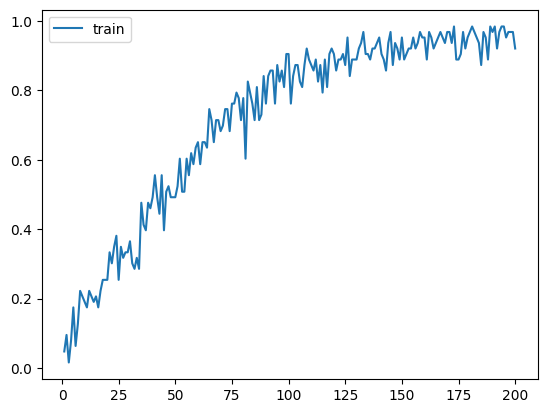

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [ ]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

**El codigo generado permite:**
  1.   Ver la carta de una roticeria
  ```
  "¿Que sabores de pizza hay?", "Me podes decir los sabores de empandas?"
  ```
  2.  Consultar instrucciones para realizar un pedido
  ```
  "¿Como hago un pedido?"
  ```
  3.  Agregar pizzas o empanadas al pedido
  ```
  "Agregame 3 pizzas al pedido", "agregame 5 empanadas"
  ```
  4.  Despedirse y que informe cual es el pedido
  ```
  "Chau", "Adios"
  ```




In [ ]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [ ]:
# Se utilizará gradio para ensayar el bot
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# !pip install linkify==1.4 linkify-it-py==2.0.2
!pip install -q gradio

In [ ]:
import gradio as gr
import random
import time

memoriaPedido_cantidad = 0

global memoriaPedido_historialArreglo
memoriaPedido_historialArreglo = []

def bot_response(human_text):
    global memoriaPedido_historialArreglo
    message = human_text
    # controla si alguna de las palabras del mensaje es un numero, lo guarda en memoriaPedido_cantidad y remplaza el numero por <cantidad>
    for word in message.split():
        if word.isdigit():
            global memoriaPedido_cantidad
            memoriaPedido_cantidad = int(word)
            message = message.replace(word, "cantidad")


    intents = pred_class(message, words, classes)

    resp = ''
    if len(intents) > 0:
        resp = get_response(intents, dataset)
        # controla si intents incluye el intent ""confirmacion_pedido_pizza" o "confirmacion_pedido_empanada"
        if "confirmacion_pedido_pizza" in intents or "confirmacion_pedido_empanada" in intents:
            # controla si memoriaPedido_cantidad es mayor a 0, en ese caso agrega la cantidad al mensaje
            if memoriaPedido_cantidad > 0:
                resp = resp.replace("cantidad", str(memoriaPedido_cantidad))
            else:
                resp = resp.replace("cantidad", "una")

            # guarda el historial de pedidos
            if "confirmacion_pedido_pizza" in intents:
                memoriaPedido_historialArreglo.append( str(memoriaPedido_cantidad) + ' pizzas' )

            if "confirmacion_pedido_empanada" in intents:
                memoriaPedido_historialArreglo.append( str(memoriaPedido_cantidad) + ' empanadas' )

        # si el mensaje es de tipo despedida agrega la lista de pedidos al final
        if "despedida" in intents:
            resp = resp + ", tu pedido fue " + ', '.join(memoriaPedido_historialArreglo)

            # limpia la memoria
            memoriaPedido_cantidad = 0
            memoriaPedido_historialArreglo = []

    else: # si no hubo ningún resultado que supere el umbral
        resp = "Perdón, no comprendo la pregunta."
        # print("BOT: Perdón, no comprendo la pregunta.")
    return resp

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    submit = gr.Button("Submit")
    clear = gr.Button("Clear")

    def respond(message, chat_history):
        bot_messageReal = bot_response(message)
        chat_history.append((message, bot_messageReal))
        time.sleep(1)
        return "", chat_history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    submit.click(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

if __name__ == "__main__":
    demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 19ms/step
Keyboard interruption in main thread... closing server.


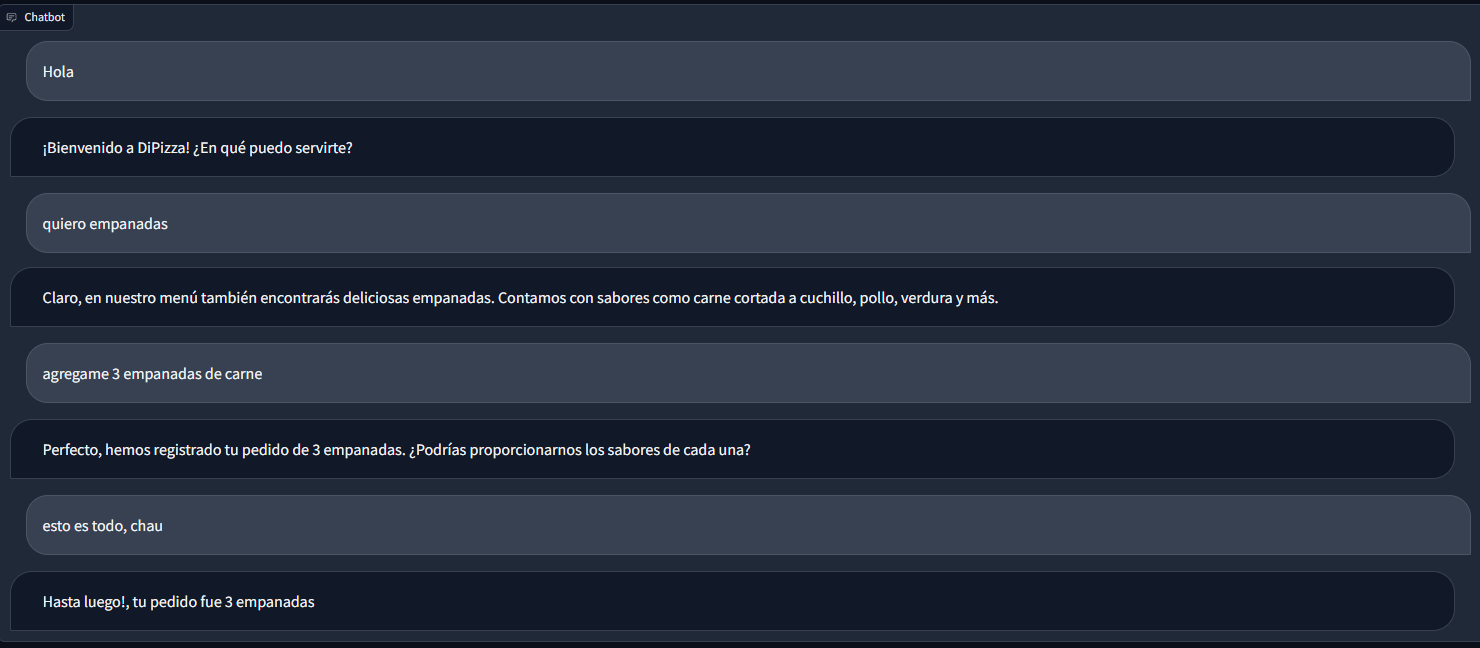

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

## Cambios realizados:
#### Diccionario:
  Se genero un diccionario donde se pretende poder responder a los pedidos de una rotisería, pudiendo pedir pizzas y empanadas de diferentes variedades, consultar métodos de pago y envió.

### Identificación de palabra clave para cantidad de pedido
  Se identifico la palabra clave "cantidad" y sus equivalentes numéricos (1,2,3,etc) junto a las clases "confirmacion_pedido_pizza" y "confirmacion_pedido_empanada", para detectar que se estaba pidiendo y cuánto. Estos datos se almacenan en una variable de pedidos que se devuelve al detectar la clase de "despedida".

### Filtrado de stop words
  Se filtraron las palabras detectadas como stop words por spacy-stanza. Esto redujo la cantidad de palabras del vocabulario de 79 a 54, lo cual hizo que la red de clasificación sea más liviana, recudiéndose de 19,471 parámetros entrenables a 16,271 parámetros entrenables.

  A pesar de la reducción de parámetros y vocabulario no se detectó un peor desempeño en el chatbot. El entorno de prueba es muy acotado para afirmar que esta técnica no modifica el desempeño.
